# Redo results after rewriting parts of the framework

2018-08-01

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
%matplotlib inline

---

In [3]:
def get_dw_dict(nodes_df):
    return {
        row.node_id : row.deepwalk_id
        for row in nodes_df.itertuples()
    }

def get_embd_dict(embd_df):
    return {
        # assumes that the row is well ordered...
        row[1] : np.array(row[2:])
#         row.deepwalk_id : np.array(row[2:])
        for row in embd_df.itertuples()
    }

In [11]:
def eval_performance(idx, vecsize):
    
    # set parameters

    train_fname = "data/min_hetionet/test/train_{}.tsv".format(idx)
    holdout_fname = "data/min_hetionet/test/holdout_{}.tsv".format(idx)

    embedding_fname = "data/min_hetionet/minhet_emb_{}.txt".format(vecsize)

    nodes_fname = "data/hetionet/deepwalk_ids.tsv"

    # read data
    
    train_df = pd.read_csv(train_fname, sep='\t')
    holdout_df = pd.read_csv(holdout_fname, sep='\t')

    embd = pd.read_csv(
        embedding_fname, sep=" ", skiprows=1,
        names=["deepwalk_id"] + ["f{}".format(i) for i in range(vecsize)]
    )
    

    nodes = pd.read_csv(nodes_fname, sep='\t')
    
    #--------------------------------------
    
    # figure out which part of the train df is useable (has deepwalk ids)

    # node ids of all nodes with a deepwalk embedding
    has_embd = set(embd[["deepwalk_id"]]
        .merge(nodes, how="left", on="deepwalk_id")
        ["node_id"]
    )

    untrainable = train_df.query("chemical_id not in @has_embd or disease_id not in @has_embd")

    print("Cannot train on {} positive and {} negative examples".format(
        untrainable["etype"].sum(), len(untrainable) - untrainable["etype"].sum()
    ))

    trainable = (train_df
        .query("chemical_id in @has_embd and disease_id in @has_embd")
        .reset_index(drop=True) # necessary because removed some rows in previous step
    )
    
    #-----------------------------------------
    
    def get_dotproduct(df):
        res = []
        for row in df.itertuples():
            dw_chem = dw_dict[row.chemical_id]
            dw_dise = dw_dict[row.disease_id]

            res.append(embd_dict[dw_chem] * embd_dict[dw_dise])

        return pd.DataFrame(res, columns=["dot{}".format(i) for i in range(vecsize)])

    dw_dict = get_dw_dict(nodes)
    embd_dict = get_embd_dict(embd)

    dotp = get_dotproduct(trainable)

    feat_train = pd.concat([trainable, get_dotproduct(trainable)], axis=1)
    
    #--------------------------
    
    regmodel = LogisticRegression()
    
    regmodel.fit(dotp, list(trainable["etype"]))
    
    untestable = (holdout_df
        .query("chemical_id not in @has_embd or disease_id not in @has_embd")
        .assign(pred_prob = 0)
    )
    
    testable = (holdout_df
        .query("chemical_id in @has_embd and disease_id in @has_embd")
        .drop("etype", axis=1)
        .reset_index(drop=True)
    )
    
    test_dot = get_dotproduct(testable)
    
    predictions = (testable
        .assign(pred_prob = regmodel.predict_proba(test_dot)[:, 1])
        .merge(holdout_df, how="left", on=["chemical_id", "disease_id"])
        .append(untestable)
        .reset_index(drop=True)
    )
    
    return predictions

In [5]:
def make_ROC(K, vecsize):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(8, 8))

    for idx in range(K):
        res = eval_performance(idx, vecsize)

        fpr, tpr, thresh = roc_curve(list(res["etype"]), list(res["pred_prob"]))

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0
        auc_val = auc(fpr, tpr)
        aucs.append(auc_val)

        plt.plot(fpr, tpr, lw=1, alpha=0.3)

    # ---------------    

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(
        mean_fpr, mean_tpr, color='b',
        label="Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr, tprs_lower, tprs_upper, color='grey',
        alpha=0.2, label="$\pm$ one sigma"
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROCs")

    plt.legend(loc="lower right")
    plt.show()

Cannot train on 8 positive and 26 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 33 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 26 negative examples


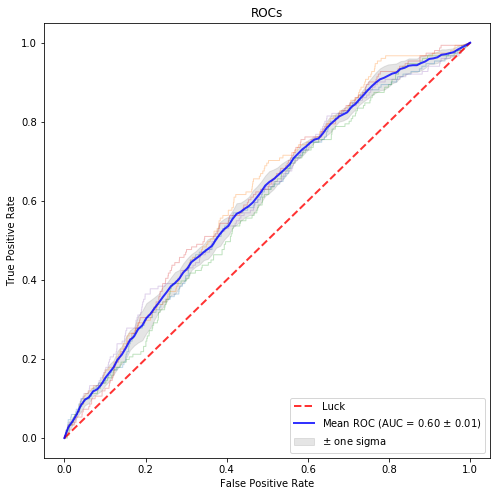

In [6]:
make_ROC(5, 8)

Cannot train on 8 positive and 26 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 33 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 26 negative examples


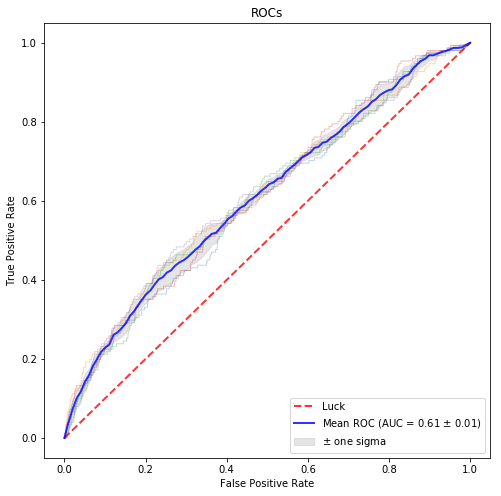

In [7]:
make_ROC(5, 16)

Cannot train on 8 positive and 26 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 33 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 26 negative examples


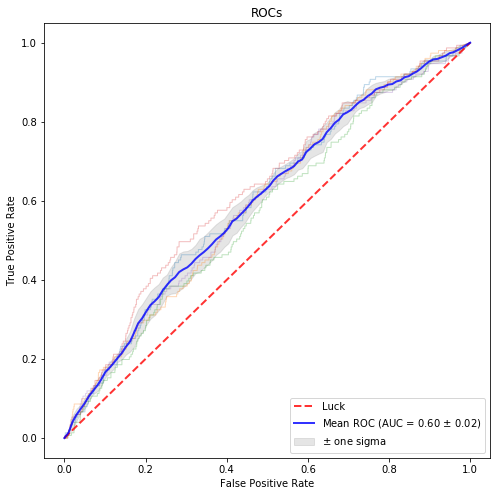

In [8]:
make_ROC(5, 32)

Cannot train on 8 positive and 26 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 33 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 26 negative examples


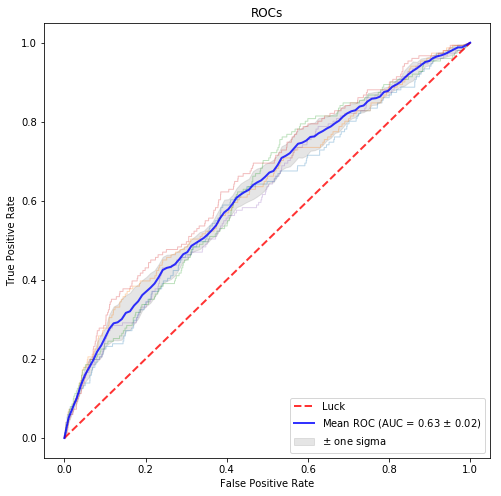

In [9]:
make_ROC(5, 64)

Cannot train on 8 positive and 26 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 33 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 26 negative examples


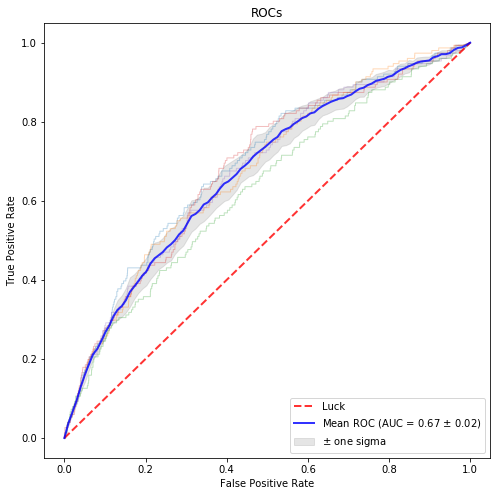

In [10]:
make_ROC(5, 128)

Cannot train on 8 positive and 26 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 33 negative examples
Cannot train on 8 positive and 33 negative examples
Cannot train on 6 positive and 26 negative examples


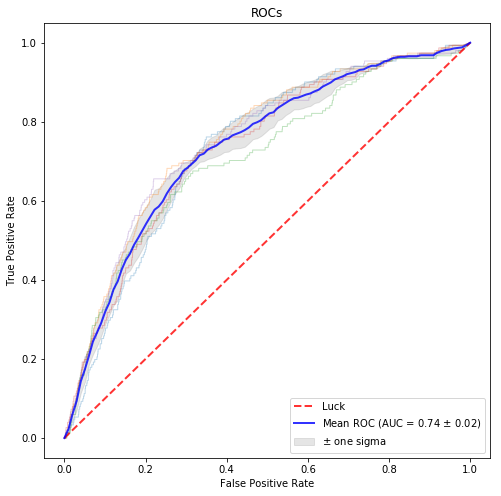

In [12]:
make_ROC(5, 1024)

---

In [3]:
# eval performance

idx = 0
vecsize = 8

In [4]:
# read data

train_fname = "data/min_hetionet/test/train_{}.tsv".format(idx)
holdout_fname = "data/min_hetionet/test/holdout_{}.tsv".format(idx)

embedding_fname = "data/min_hetionet/minhet_emb_{}.txt".format(vecsize)

nodes_fname = "data/hetionet/deepwalk_ids.tsv"

In [5]:
train_df = pd.read_csv(train_fname, sep='\t')
holdout_df = pd.read_csv(holdout_fname, sep='\t')

embd = pd.read_csv(
    embedding_fname, sep=" ", skiprows=1,
    names=["deepwalk_id"] + ["f{}".format(i) for i in range(vecsize)]
)

nodes = pd.read_csv(nodes_fname, sep='\t')

---

In [6]:
# figure out which part of the train df is useable (has deepwalk ids)

# node ids of all nodes with a deepwalk embedding
has_embd = set(
    embd
    [["deepwalk_id"]]
    .merge(nodes, how="left", on="deepwalk_id")
    ["node_id"]
)

untrainable = train_df.query("chemical_id not in @has_embd or disease_id not in @has_embd")

print("Cannot train on {} positive and {} negative examples".format(
    untrainable["etype"].sum(), len(untrainable) - untrainable["etype"].sum()
))

trainable = (train_df
    .query("chemical_id in @has_embd and disease_id in @has_embd")
    .reset_index(drop=True) # necessary because removed some rows in previous step
)

Cannot train on 8 positive and 26 negative examples


In [7]:
def get_dotproduct(df):
    res = []
    for row in df.itertuples():
        dw_chem = dw_dict[row.chemical_id]
        dw_dise = dw_dict[row.disease_id]
        
        res.append(embd_dict[dw_chem] * embd_dict[dw_dise])

    return pd.DataFrame(res, columns=["dot{}".format(i) for i in range(vecsize)])

dw_dict = get_dw_dict(nodes)
embd_dict = get_embd_dict(embd)

dotp = get_dotproduct(trainable)

feat_train = pd.concat([trainable, get_dotproduct(trainable)], axis=1)

---

In [10]:
regmodel = LogisticRegression()

In [11]:
regmodel.fit(dotp, list(trainable["etype"]))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

---

In [12]:
untestable = holdout_df.query("chemical_id not in @has_embd or disease_id not in @has_embd")

In [13]:
untestable.shape

(117, 3)

In [15]:
untested = untestable.assign(pred_prob = 0)

In [17]:
untestable["etype"].value_counts()

0    116
1      1
Name: etype, dtype: int64

In [18]:
testable = (holdout_df
    .query("chemical_id in @has_embd and disease_id in @has_embd")
    .drop("etype", axis=1)
    .reset_index(drop=True)
)

In [20]:
testable.head()

,chemical_id,disease_id
0,DB00552,DOID:2531
1,DB00509,DOID:1459
2,DB00947,DOID:1612
3,DB00966,DOID:3393
4,DB00523,DOID:1192


In [21]:
test_dot = get_dotproduct(testable)

In [22]:
test_dot.head()

,dot0,dot1,dot2,dot3,dot4,dot5,dot6,dot7
0,-14.174102,23.317262,24.651008,4.279940,4.425072,-17.292202,-13.251912,-2.460726
1,-21.823713,-6.432529,0.508069,-3.483853,0.105016,47.925823,3.739436,-26.840823
2,-2.959467,95.055987,-35.422496,1.192345,-4.692240,13.437481,15.778623,-178.436721
3,4.129837,17.643874,48.680146,7.113192,-56.453955,92.730767,7.263622,-16.354166
4,-109.987466,-26.261370,100.932847,0.087428,18.069785,-72.264000,24.297640,-109.999480


In [23]:
res = regmodel.predict_proba(test_dot)[:, 1]

In [25]:
tested = testable.assign(pred_prob = res)

In [26]:
res

array([ 0.18665541,  0.20000395,  0.462685  , ...,  0.22927257,
        0.22233536,  0.23868395])

---

In [28]:
tested.head()

,chemical_id,disease_id,pred_prob
0,DB00552,DOID:2531,0.186655
1,DB00509,DOID:1459,0.200004
2,DB00947,DOID:1612,0.462685
3,DB00966,DOID:3393,0.255715
4,DB00523,DOID:1192,0.064929


In [31]:
untested.head()

,chemical_id,disease_id,etype,pred_prob
81,DB00987,DOID:0060073,1,0
172,DB00675,DOID:0060073,0,0
223,DB00331,DOID:0060073,0,0
249,DB00654,DOID:0060073,0,0
319,DB00539,DOID:0060073,0,0


In [41]:
fin_tested = (tested
    .merge(holdout_df, how="left", on=["chemical_id", "disease_id"])
    .append(untested)
    .reset_index(drop=True)
)

In [42]:
fin_tested.head()

,chemical_id,disease_id,etype,pred_prob
0,DB00552,DOID:2531,1,0.186655
1,DB00509,DOID:1459,1,0.200004
2,DB00947,DOID:1612,1,0.462685
3,DB00966,DOID:3393,1,0.255715
4,DB00523,DOID:1192,1,0.064929


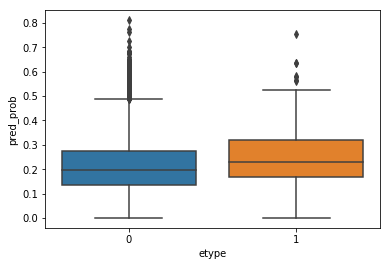

In [51]:
sns.boxplot(data=fin_tested, x="etype", y="pred_prob")

In [52]:
fpr, tpr, thresh = roc_curve(list(fin_tested["etype"]), list(fin_tested["pred_prob"]))

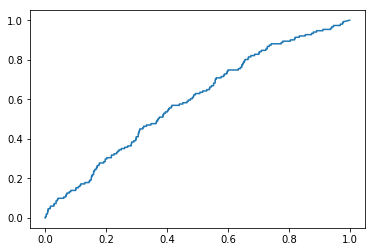

In [53]:
plt.plot(fpr, tpr)

In [54]:
auc(fpr, tpr)

0.59380102923822609